## Experiments on synthetic data

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

from sklearn.model_selection import train_test_split  # noqa: E402
from sklearn.metrics import balanced_accuracy_score, f1_score  # noqa: E402

from algorithm.ccd import LogRegCCD  # noqa: E402
from datasets.synthetic import generate_synthetic_data  # noqa: E402

### Impact of dataset parameters n, p, d, g on the performance of LogRegCCD algorithm 

In [9]:
n = [100, 1000, 10000]
p = np.arange(0.0, 1.0, 0.1)
d = [10, 100, 1000]
g = [0.0, 0.5, 1.0]
TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2
np.random.seed(42)
results = []
for params in ParameterGrid({"n": n, "p": p, "d": d, "g": g}):
    X, y = generate_synthetic_data(
        n=params["n"], p=params["p"], d=params["d"], g=params["g"]
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 - TRAIN_SIZE, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE), random_state=42
    )
    model = LogRegCCD()
    model.fit(X_train, y_train)
    model.validate(X_val, y_val, measure="F-measure")
    y_pred = model.predict_proba(X_test) >= 0.5
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append(
        {
            "n": params["n"],
            "p": params["p"],
            "d": params["d"],
            "g": params["g"],
            "balanced_accuracy": balanced_accuracy,
            "f1_score": f1,
        }
    )
    print(
        f"n: {params['n']}, p: {params['p']}, d: {params['d']}, g: {params['g']}, "
        f"balanced_accuracy: {balanced_accuracy:.4f}, f1_score: {f1:.4f}"
    )

n: 100, p: 0.0, d: 10, g: 0.0, balanced_accuracy: 1.0000, f1_score: 0.0000
n: 100, p: 0.1, d: 10, g: 0.0, balanced_accuracy: 0.5000, f1_score: 0.0000
n: 100, p: 0.2, d: 10, g: 0.0, balanced_accuracy: 0.5000, f1_score: 0.0000
n: 100, p: 0.30000000000000004, d: 10, g: 0.0, balanced_accuracy: 0.4375, f1_score: 0.0000
n: 100, p: 0.4, d: 10, g: 0.0, balanced_accuracy: 0.6703, f1_score: 0.5714
n: 100, p: 0.5, d: 10, g: 0.0, balanced_accuracy: 0.6044, f1_score: 0.8000
n: 100, p: 0.6000000000000001, d: 10, g: 0.0, balanced_accuracy: 0.5625, f1_score: 0.7742
n: 100, p: 0.7000000000000001, d: 10, g: 0.0, balanced_accuracy: 0.6429, f1_score: 0.8387
n: 100, p: 0.8, d: 10, g: 0.0, balanced_accuracy: 1.0000, f1_score: 1.0000
n: 100, p: 0.9, d: 10, g: 0.0, balanced_accuracy: 0.5000, f1_score: 0.9189
n: 1000, p: 0.0, d: 10, g: 0.0, balanced_accuracy: 1.0000, f1_score: 0.0000
n: 1000, p: 0.1, d: 10, g: 0.0, balanced_accuracy: 0.6053, f1_score: 0.3429
n: 1000, p: 0.2, d: 10, g: 0.0, balanced_accuracy: 0

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LinearRegression

df_results = pd.DataFrame(results)
X = df_results[["n", "p", "d", "g"]]
y = df_results["f1_score"]

linear_model = LinearRegression()
linear_model.fit(X, y)

# See coefficients
coef_summary = pd.DataFrame({"Feature": X.columns, "Coefficient": linear_model.coef_})
print(coef_summary)

  Feature  Coefficient
0       n     0.000004
1       p     0.894255
2       d     0.000034
3       g     0.285085


In [12]:
y2 = df_results["balanced_accuracy"]

linear_model2 = LinearRegression()
linear_model2.fit(X, y2)
coef_summary2 = pd.DataFrame({"Feature": X.columns, "Coefficient": linear_model2.coef_})
print(coef_summary2)

  Feature   Coefficient
0       n  1.977175e-06
1       p -3.298693e-01
2       d  1.428833e-07
3       g  2.012541e-01


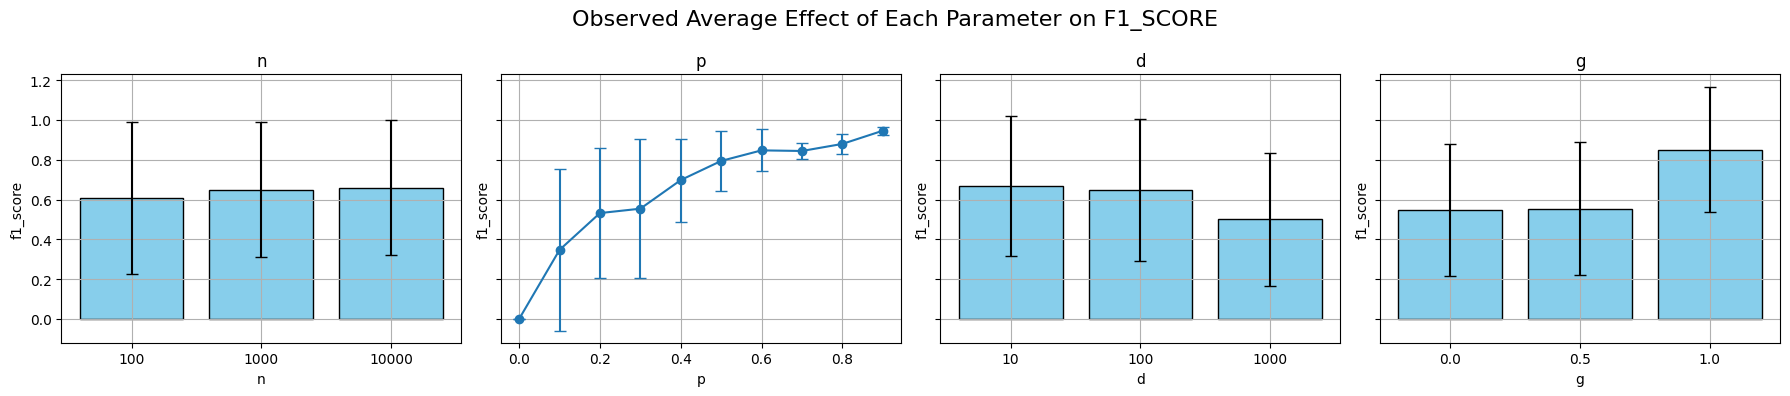

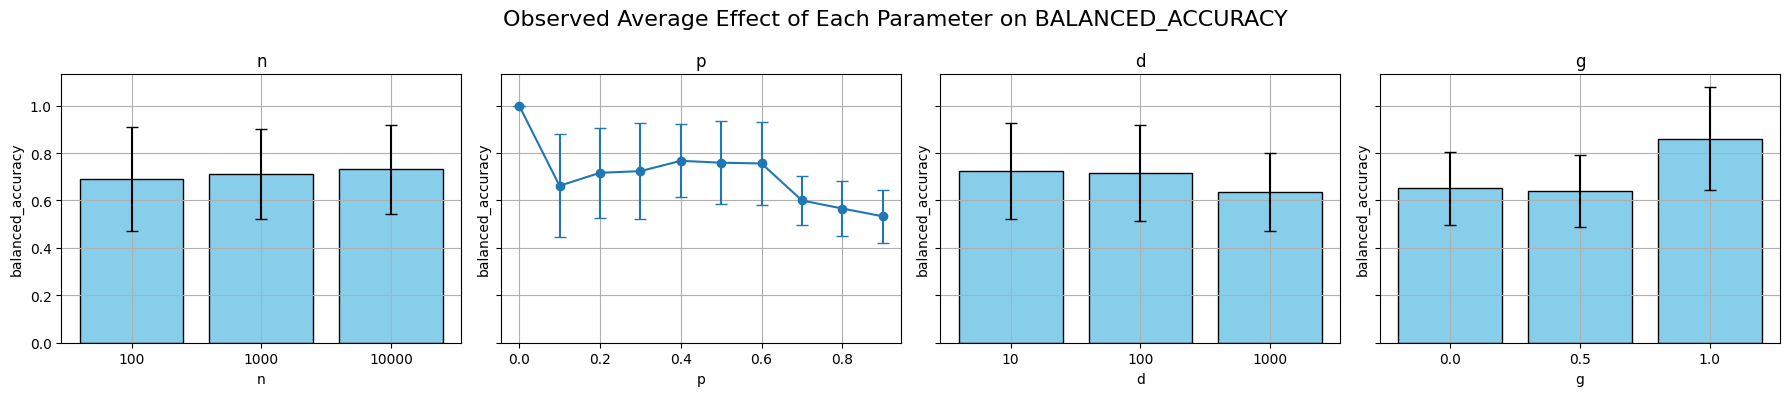

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
metrics = ["f1_score", "balanced_accuracy"]
features = ["n", "p", "d", "g"]

for metric in metrics:
    fig, axes = plt.subplots(1, len(features), figsize=(18, 4), sharey=True)
    fig.suptitle(
        f"Observed Average Effect of Each Parameter on {metric.upper()}", fontsize=16
    )

    for i, feature in enumerate(features):
        # Group by the feature and calculate mean and std
        grouped = df_results.groupby(feature)[metric].agg(["mean", "std"]).reset_index()
        if feature == "p":
            axes[i].errorbar(
                grouped[feature],
                grouped["mean"],
                yerr=grouped["std"],
                fmt="-o",
                capsize=4,
            )

        else:
            axes[i].bar(
                grouped[feature].astype(str),
                grouped["mean"],
                yerr=grouped["std"],
                capsize=4,
                color="skyblue",
                edgecolor="black",
            )
        axes[i].set_title(f"{feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(metric)
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()